# Predicting Real Disasters from Twitter

Frame the problem.

# Data

Discuss putting the data into a Postgres database.

In [27]:
from sqlalchemy import create_engine

db_pw = open('C:/Users/Jake/Documents/Projects/jakes_db.txt').read()

engine = create_engine('postgresql://postgres:%s@localhost:5432/disaster' % db_pw)
conn = engine.connect()

In [28]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

train = pd.read_sql('SELECT * FROM train;', conn)

Take a look at the first 5 rows.

In [29]:
train.head()

,index,id,keyword,location,text,target
0,0,1,None,None,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,2,5,None,None,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,3,6,None,None,"13,000 people receive #wildfires evacuation orders in California",1
4,4,7,None,None,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [30]:
train.shape

(7613, 6)

In [31]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Data Cleaning Function

2. Tokenize
3. Clean Text - stopwords, punctuation, lower case, lemmatize/stem

In [32]:
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_tweets(tweet):
    tweet = ''.join([c.lower() for c in tweet if c not in string.punctuation]) #remove punctuation
    tweet = re.split('\W+', tweet) #tokenize tweet
    tweet = [wn.lemmatize(word) for word in tweet if word not in stopwords and word != ''] #remove stopwords & lemmatize
    return(tweet)

train['clean_tweet'] = train['text'].apply(lambda x: clean_tweets(x))
train.head()

,index,id,keyword,location,text,target,clean_tweet
0,0,1,None,None,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"[deed, reason, earthquake, may, allah, forgive, u]"
1,1,4,None,None,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,2,5,None,None,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,"[resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]"
3,3,6,None,None,"13,000 people receive #wildfires evacuation orders in California",1,"[13000, people, receive, wildfire, evacuation, order, california]"
4,4,7,None,None,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]"


# Feature Engineering

In [33]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

def evaluate_feature(feature_name, bins):
    pyplot.hist(train[train['target'] == 1][feature_name], bins, alpha=0.5, label='disaster')
    pyplot.hist(train[train['target'] == 0][feature_name], bins, alpha=0.5, label='not disaster')
    pyplot.legend(loc='upper left')
    pyplot.title(feature_name)
    pyplot.show()

## Tweet Length

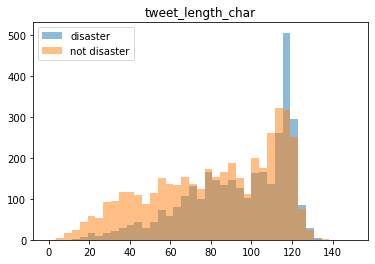

In [34]:
train['tweet_length_char'] = train['text'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0,150, 40)
evaluate_feature('tweet_length_char', bins)

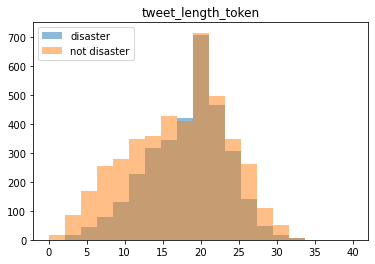

In [35]:
train['tweet_length_token'] = train['text'].apply(lambda x: len(re.split('\W+', x)))

bins = np.linspace(0,40, 20)
evaluate_feature('tweet_length_token', bins)

## Hashtags & Punctuation

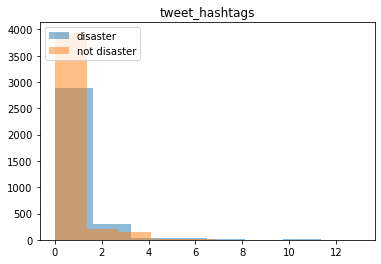

In [36]:
train['tweet_hashtags'] = train['text'].apply(lambda x: sum([1 for c in x if c == '#']))

evaluate_feature('tweet_hashtags', 8)

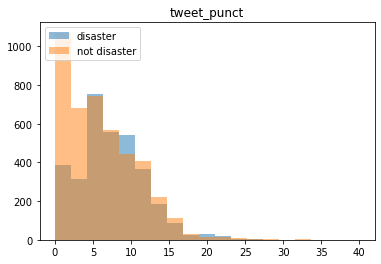

In [37]:
train['tweet_punct'] = train['text'].apply(lambda x: sum([1 for c in x if c in string.punctuation]))

bins = np.linspace(0,40, 20)
evaluate_feature('tweet_punct', bins)

## Keyword and Location

In [38]:
train.groupby('location').size().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Length: 3341, dtype: int64

In [39]:
def tweet_location(location):
    if location == None:
        return(0)
    return(1)

train['has_location'] = train['location'].apply(lambda x: tweet_location(x))
location_summary = train.groupby(['target', 'has_location']).size().to_frame('size').reset_index()
location_summary.pivot(index='target',columns='has_location',values='size')

has_location,0,1
target,,
0,1458,2884
1,1075,2196


In [40]:
def tweet_keyword(kw):
    if kw == None:
        return(0)
    return(1)

train['has_keyword'] = train['keyword'].apply(lambda x: tweet_keyword(x))
location_summary = train.groupby(['target', 'has_keyword']).size().to_frame('size').reset_index()
location_summary.pivot(index='target',columns='has_keyword',values='size')

has_keyword,0,1
target,,
0,19,4323
1,42,3229


# Vectorize

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [42]:
count_vect = CountVectorizer(analyzer=clean_tweets)
count_fit = count_vect.fit_transform(train['text'])

count_X_features = pd.concat([train[['tweet_length_char', 'tweet_length_token', 'tweet_hashtags', 'tweet_punct']], 
                        pd.DataFrame(count_fit.toarray())], axis=1)
count_X_features.head()

,tweet_length_char,tweet_length_token,tweet_hashtags,tweet_punct,0,1,2,3,4,5,...,20989,20990,20991,20992,20993,20994,20995,20996,20997,20998
0,57,13,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32,7,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,112,22,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57,10,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,17,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
tfidf_vect = TfidfVectorizer(analyzer=clean_tweets)
tfidf_fit = tfidf_vect.fit_transform(train['text'])

tfidf_X_features = pd.concat([train[['tweet_length_char', 'tweet_length_token', 'tweet_hashtags', 'tweet_punct']], 
                        pd.DataFrame(tfidf_fit.toarray())], axis=1)
tfidf_X_features.head()

,tweet_length_char,tweet_length_token,tweet_hashtags,tweet_punct,0,1,2,3,4,5,...,20989,20990,20991,20992,20993,20994,20995,20996,20997,20998
0,57,13,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,7,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,112,22,0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57,10,1,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72,17,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Applying Machine Learning Algorithms

In [45]:
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [46]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(count_X_features, train['target'], test_size=0.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_X_features, train['target'], test_size=0.2)

## Random Forrest

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)

### Count Vectorizer

In [48]:
rf_count_model = rf_clf.fit(X_train_count, y_train_count)
cv_results = cross_validate(lasso, X, y, cv=3)
sorted(zip(rf_count_model.feature_importances_, X_train_count.columns), reverse=True)[0:10]

[(0.04010564827327655, 'tweet_punct'),
 (0.026932014640857604, 'tweet_length_token'),
 (0.02552709530798642, 'tweet_length_char'),
 (0.02119306032337233, 12843),
 (0.013547137806590488, 18563),
 (0.012407271335136694, 5724),
 (0.011158152137509543, 14020),
 (0.010594051887823062, 2733),
 (0.010451209599296298, 2338),
 (0.010431614096997919, 1602)]

Precision = % of predicted disasters that are disasters  
Recall = % of disaster tweets identified by model

In [49]:
y_pred_count = rf_count_model.predict(X_test_count)
precision, recall, fscore, support = score(y_test_count, y_pred_count, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred_count==y_test_count).sum() / len(y_pred_count),3)))

Precision: 0.98 / Recall: 0.29 / Accuracy: 0.686


### TF-Idf Vectorizer

In [50]:
rf_tfidf_model = rf_clf.fit(X_train_tfidf, y_train_tfidf)
sorted(zip(rf_tfidf_model.feature_importances_, X_train_tfidf.columns), reverse=True)[0:10]

[(0.036200933929045005, 'tweet_punct'),
 (0.025449838271817057, 5724),
 (0.02398532910046146, 'tweet_length_token'),
 (0.019288302597784534, 18563),
 (0.019013378138568494, 'tweet_length_char'),
 (0.016036046992999372, 12843),
 (0.014684442478382756, 14020),
 (0.013627690676840864, 20445),
 (0.012245840141148035, 2733),
 (0.012053292785063436, 7001)]

In [51]:
y_pred_tfidf = rf_tfidf_model.predict(X_test_tfidf)
precision, recall, fscore, support = score(y_test_tfidf, y_pred_tfidf, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred_tfidf==y_test_tfidf).sum() / len(y_pred_tfidf),3)))

Precision: 0.966 / Recall: 0.297 / Accuracy: 0.687


## Gridsearch Best Model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [12]:
rf = RandomForestClassifier(n_jobs=-1)
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, 120, None],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 10, 20]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_features, train['target'])
rf_gs_results = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)
rf_gs_results[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
71,114.563360,8.959216,3.786686,1.154666,entropy,90,20,300,"{'criterion': 'entropy', 'max_depth': 90, 'min_samples_split': 20, 'n_estimators': 300}",0.696651,0.647406,0.675640,0.647832,0.746386,0.682783,0.036775,1
32,148.300025,17.101207,4.583046,2.226819,gini,120,10,300,"{'criterion': 'gini', 'max_depth': 120, 'min_samples_split': 10, 'n_estimators': 300}",0.699934,0.639527,0.665791,0.654402,0.749014,0.681734,0.039091,2
34,82.402567,5.287477,2.957500,1.147682,gini,120,20,150,"{'criterion': 'gini', 'max_depth': 120, 'min_samples_split': 20, 'n_estimators': 150}",0.695338,0.650689,0.671044,0.647175,0.743101,0.681470,0.035279,3
22,78.323160,3.967970,2.913709,1.458264,gini,90,10,150,"{'criterion': 'gini', 'max_depth': 90, 'min_samples_split': 10, 'n_estimators': 150}",0.692055,0.644780,0.665135,0.653088,0.751643,0.681340,0.038613,4
74,163.393412,21.079034,3.646602,1.709538,entropy,120,2,300,"{'criterion': 'entropy', 'max_depth': 120, 'min_samples_split': 2, 'n_estimators': 300}",0.701904,0.642810,0.670387,0.640604,0.750986,0.681338,0.041321,5


In [19]:
rf_model_dir = 'C:/Users/Jake/Documents/Projects/Disaster-Tweets/models/random_forest'

rf_gs_results = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)
rf_gs_results.to_excel(rf_model_dir + '/rf_gs_results.xlsx', index=False)

dump(gs_fit.best_estimator_, rf_model_dir + '/rf_best.joblib')

['C:/Users/Jake/Documents/Projects/Disaster-Tweets/models/random_forest/rf_best.joblib']

In [20]:
rf_best = load(rf_model_dir + '/rf_best.joblib') 

### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(cache_size=4000)
param_svm = {'C': [1.0, 0.75, 0.5, 0.25],
             'kernel': ['linear', 'rbf', 'poly']}

gs_svm = GridSearchCV(svm, param_svm, cv=3, n_jobs=-1)
gs_svm_fit = gs_svm.fit(X_features, train['target'])

svm_gs_results = pd.DataFrame(gs_svm_fit.cv_results_).sort_values('mean_test_score', ascending=False)
svm_gs_results[0:5]